In [2]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm


df_krx = fdr.StockListing('KRX') # 한국거래소 상장종목 전체
ticker = df_krx[df_krx.Name=='삼성전자']['Code'] # 티커
samsung = fdr.DataReader(ticker.values[0],start='2022-02-01',end = '2023-02-03')

In [3]:
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-02-03,74900,74900,73300,73300,17744721,0.000000
2022-02-04,74300,74600,73400,74000,12730034,0.009550
2022-02-07,73500,73600,72400,73000,14240838,-0.013514
2022-02-08,73800,74200,73000,73500,11736666,0.006849
2022-02-09,74300,74700,74000,74700,9699122,0.016327
...,...,...,...,...,...,...
2023-01-30,64900,64900,63100,63300,20995234,-0.020124
2023-01-31,63500,63700,61000,61000,29746731,-0.036335
2023-02-01,62600,62700,61000,61800,18570133,0.013115


<AxesSubplot:xlabel='Date'>

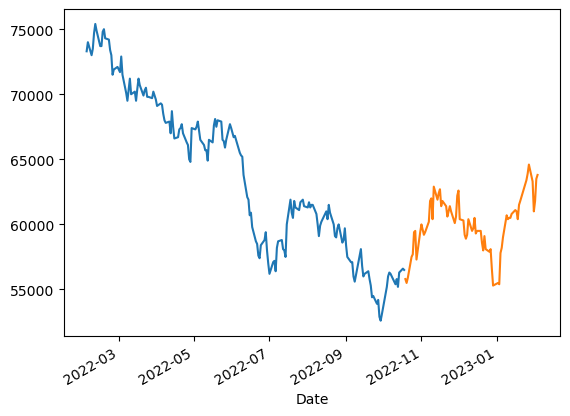

In [5]:
y_train = samsung['Close'][:int(0.7*len(samsung))]
y_test = samsung['Close'][int(0.7*len(samsung)):]
y_train.plot()
y_test.plot()

## - 정상성은 확실히 만족하지 않겠다 -> 차분이 꼭 필요하겠다 -> ARIMA의 차수 d가 1 이상이겠구나라 생각해볼 수 있고
- 상승 추세가 있긴 하지만, 최근에 와서 주춤하는 모습을 보인다. -> 상수항이 없는 임의 보행 모형은 아닐까?라 생각해볼 수 있고
- 계절성이나 주기성은 크게 보이진 않기 때문에 관련 모수 seasonal이나 m은 auto_arima에 적용할 필요는 없겠다 예상해볼 수 있습니다.

In [6]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


- y: array 형태의 시계열 자료
- d (기본값 = none): 차분의 차수, 이를 지정하지 않으면 실행 기간이 매우 길어질 수 있음
- start_p (기본값 = 2), max_p (기본값 = 5): AR(p)를 찾을 범위 (start_p에서 max_p까지 찾는다!)
- start_q (기본값 = 2), max_q (기본값 = 5): AR(q)를 찾을 범위 (start_q에서 max_q까지 찾는다!)
- m (기본값 = 1): 계절적 차분이 필요할 때 쓸 수 있는 모수로 m=4 이면 분기별, m=12면 월별, m=1이면 계절적 특징을 띠지 않는 데이터를 의미한다. m=1이면 자동적
- seasonal 에 대한 옵션은 False로 지정된다. seasonal (기본값 = True): 계절성 ARIMA 모형을 적합할지의 여부
- stepwise (기본값 = True): 최적의 모수를 찾기 위해 쓰는 힌드만 - 칸다카르 알고리즘을 사용할지의 여부, False면 모든 모수 조합으로 모형을 적합한다.
- trace (기본값 = False): stepwise로 모델을 적합할 때마다 결과를 프린트하고 싶을 때 사용한다.

In [7]:
# ARIMA 모형 적합
# 이제 모델 auto_arima 함수로 최적의 모형을 탐색해보겠습니다. 위에서 7:3의 비율로 train과 test 데이터를 나누었습니다. train 데이터로 학습을 하고, test 데이터로 예측을 해봅니다.

model = pm.auto_arima (y_train, d = 1, seasonal = False, trace = True)
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2821.814, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2826.177, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2827.454, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2827.383, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2826.458, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2828.883, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2828.647, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2828.313, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2830.902, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2830.484, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=0.16 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total 

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [8]:
## 잔차 검정
print(model.summary())
#Jarque-Bera (JB) 자크-베라 검정 통계량은 잔차가 정규성을 띠는지 검정한 통계량입니다.Prob(JB)값을 보면 0.00으로 유의 수준 0.05에서 귀무가설을 기각합니다.
#Jarque-Bera (JB) 통계량의 귀무가설은 “잔차가 정규성을 만족한다”이므로, 위 결과를 통해 “잔차가 정규성을 따르지 않음”을 확인할 수 있습니다.

#Ljung-Box (Q) 융-박스 검정 통계량는 잔차가 백색잡음인지 검정한 통계량입니다.

#Prob (Q) 값을 보면 0.65이므로 유의수준 0.05에서 귀무가설을 기각하지 못합니다. Ljung-Box (Q) 통계량의 귀무가설은 “잔차(residual)가 백색잡음(white noise) 시계열을 따른다”

#잔차가 정규분포를 따른다면, 경험적으로
#비대칭도 (Skew)는 0에 가까워야 하고
#첨도 (Kurtosis)는 3에 가까워야 합니다.

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  174
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -1404.907
Date:                Fri, 10 Feb 2023   AIC                           2821.814
Time:                        13:02:47   BIC                           2840.733
Sample:                             0   HQIC                          2829.489
                                - 174                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -133.4626    101.238     -1.318      0.187    -331.885      64.960
ar.L1          0.4375      0.013     32.802      0.000       0.411       0.464
ar.L2         -0.9858      0.015    -64.545      0.0

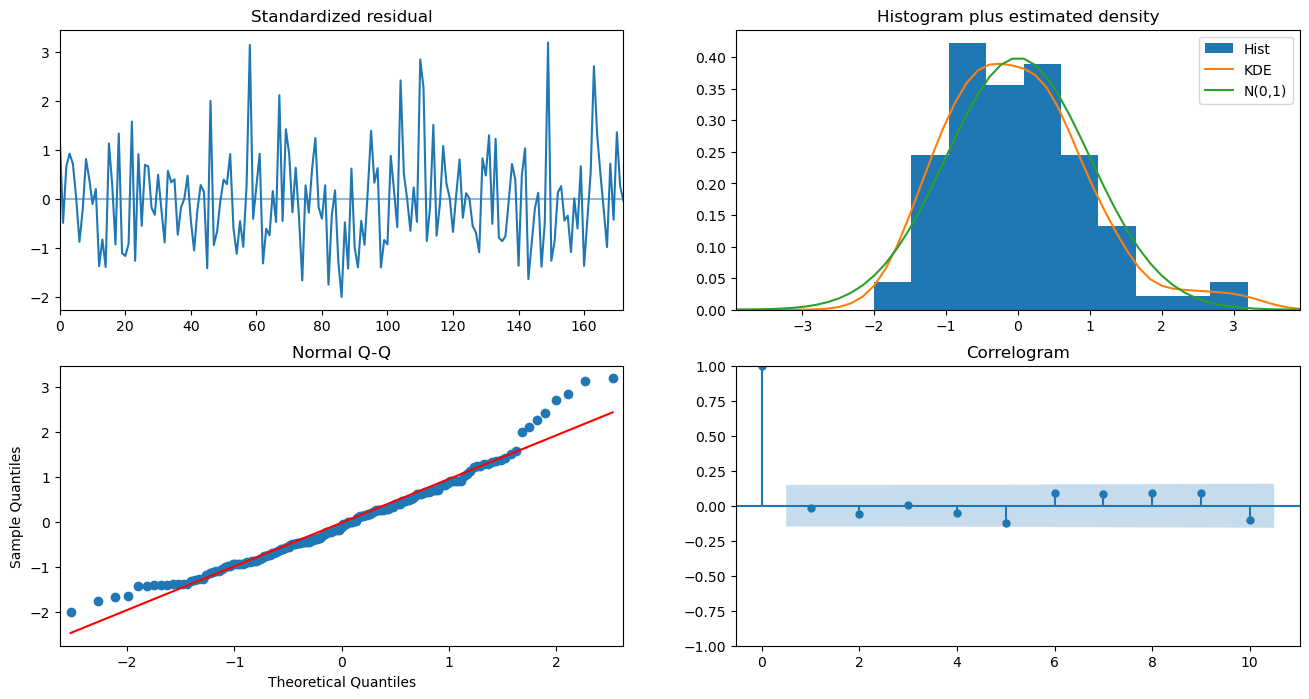

In [9]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

C:\Users\msi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


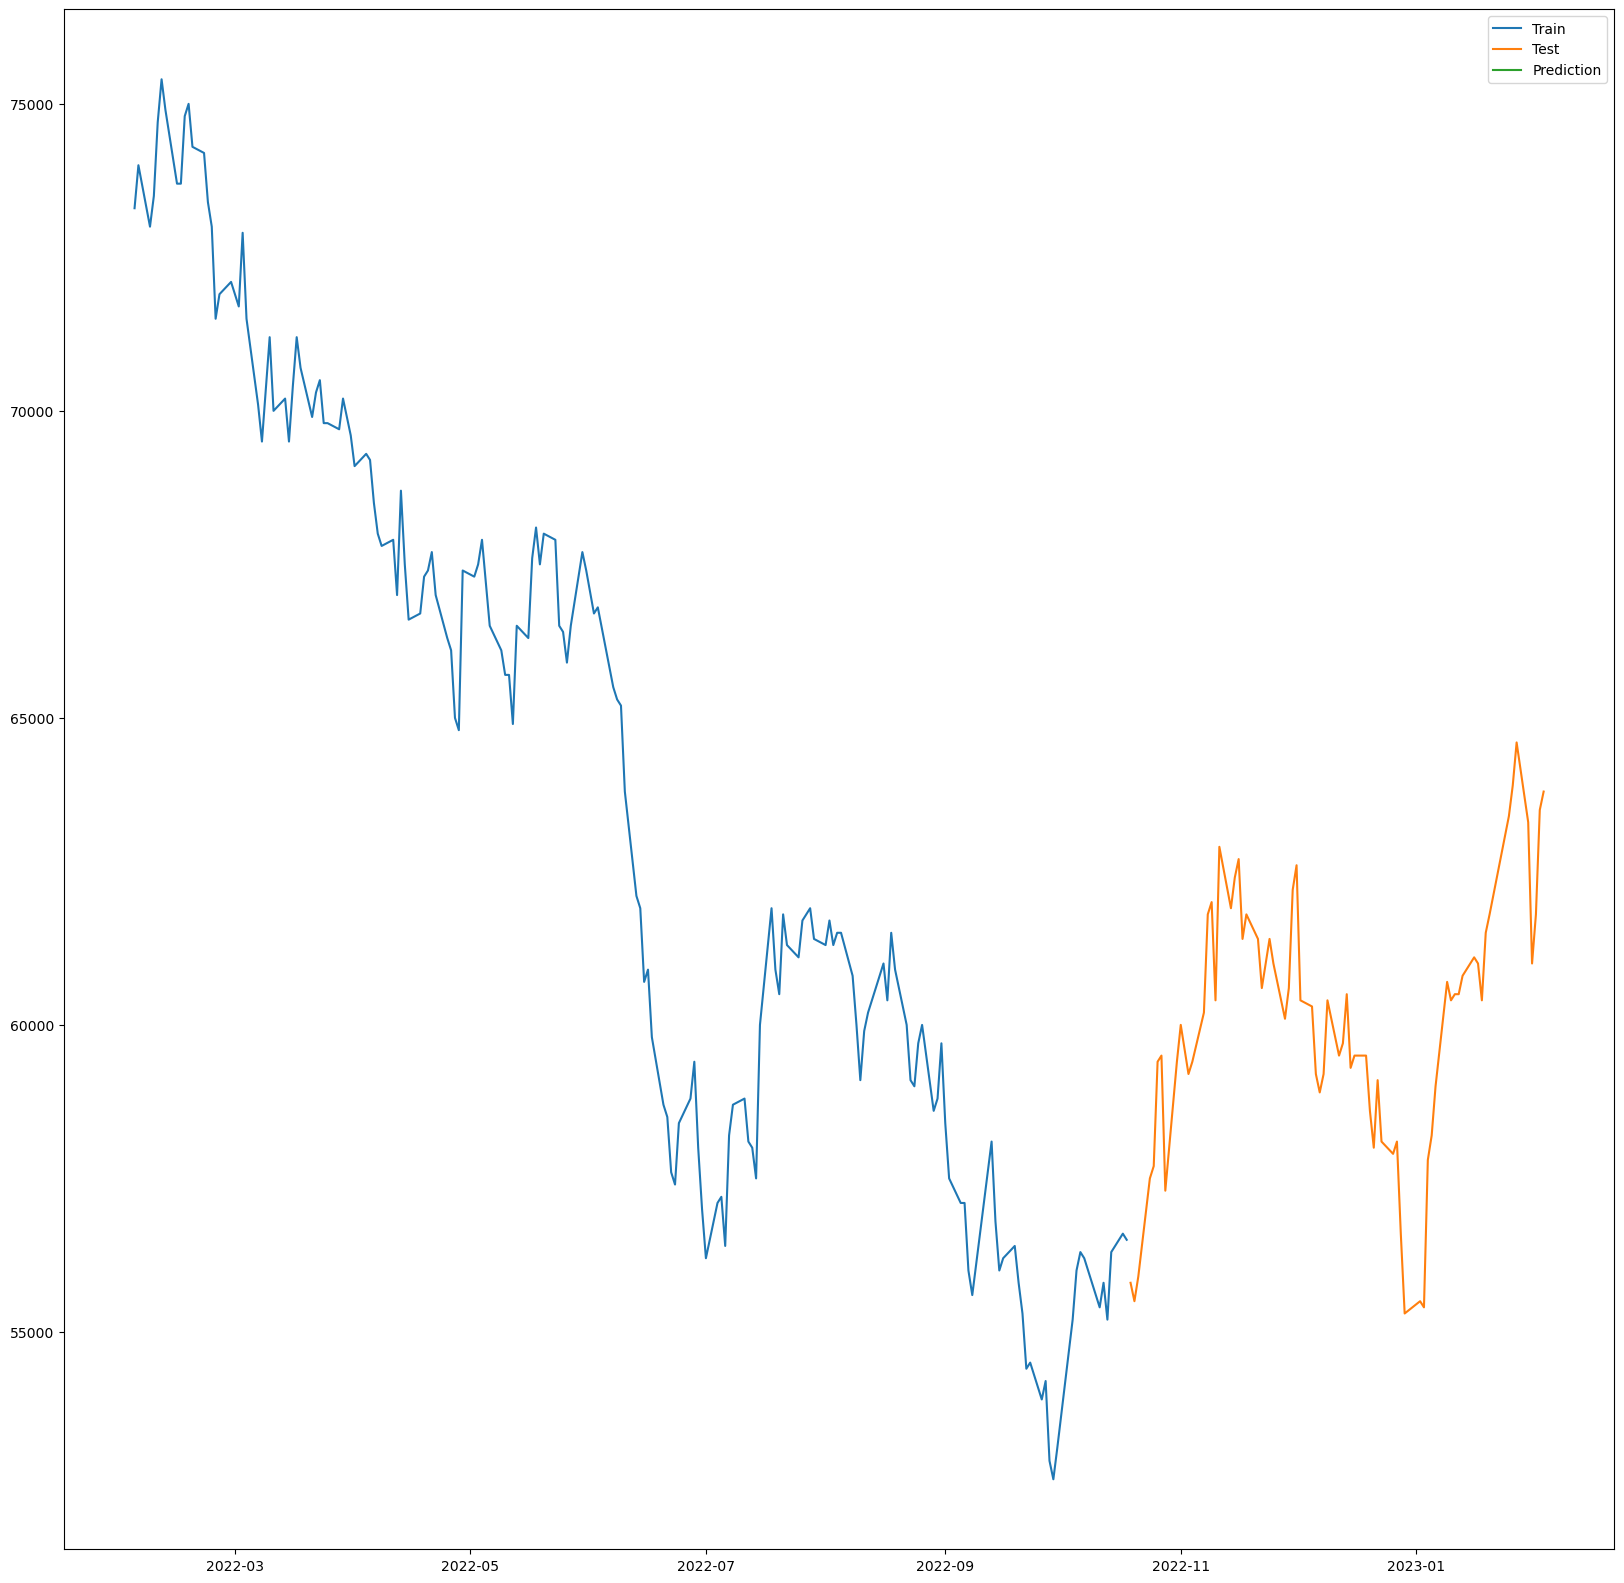

In [10]:
## 모형 refresh 및 예측
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_test)) 
y_predict = pd.DataFrame(y_predict,index = y_test.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [11]:
y_predict

,Prediction
Date,
2022-10-19,NaN
2022-10-20,NaN
2022-10-21,NaN
2022-10-24,NaN
2022-10-25,NaN
...,...
2023-01-30,NaN
2023-01-31,NaN
2023-02-01,NaN


In [12]:
# 차분은 1번한 모형을 auto arima에서 가장 적합한 모델로 선택하였다 .
#데이터에 특정한 주기나 추세가 없기 때문에, AIC로 모형을 최적화를 하는 과정에서 의미있는 자기 상관 (AR)이나 이동 평균 (MA)를 찾기 어려웠기 때문입니다.
#  한번에 테스트 데이터를 예측하는 것이 아니라, 한 스텝씩 예측하고, 테스트 데이터를 “관측”할 때마다 모형을 업데이트해주는 REFRESH 전략을 쓸 것입니다.

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [13]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

C:\Users\msi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [14]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
Date,,
2022-10-19,55800,56255.560410
2022-10-20,55500,55637.024288
2022-10-21,55900,55545.054973
2022-10-24,57500,55943.944305
2022-10-25,57700,57324.914184
...,...,...
2023-01-30,63300,64446.698138
2023-01-31,61000,63162.212976
2023-02-01,61800,60985.493732


In [15]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  249
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -2036.487
Date:                Fri, 10 Feb 2023   AIC                           4084.975
Time:                        09:45:41   BIC                           4106.055
Sample:                             0   HQIC                          4093.461
                                - 249                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -133.4622     82.247     -1.623      0.105    -294.662      27.738
ar.L1          0.4396      0.011     39.438      0.000       0.418       0.461
ar.L2         -0.9857      0.011    -85.953      0.0

In [12]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(2,1,2)모형")
fig.show()

NameError: name 'y_pred' is not defined